In [21]:
import numpy as np

X = np.array([[[1, 1, 2], [2, 3, 3]], [[1, 1, 1], [1, 1, 1]]])
X_reshaped = X.reshape(-1, X.shape[-1])
X_centered = X_reshaped - X_reshaped.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

print(f"C1: {c1}\n C2: {c2}")

C1: [0.34294171 0.68588342 0.64183714]
 C2: [ 0.28703829  0.57407659 -0.76684098]


In [22]:
W2 = Vt[:2].T
X2D = X_centered @ W2

print(X2D)

[[-0.26821786 -0.55050811]
 [ 2.08832784  0.11784237]
 [-0.91005499  0.21633287]
 [-0.91005499  0.21633287]]


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X2D = pca.fit_transform(X_reshaped)

print(X2D)

[[-2.68217856e-01  5.50508112e-01  5.24158096e-17]
 [ 2.08832784e+00 -1.17842374e-01  5.24158096e-17]
 [-9.10054993e-01 -2.16332869e-01  5.24158096e-17]
 [-9.10054993e-01 -2.16332869e-01  5.24158096e-17]]


In [24]:
pca.explained_variance_ratio_

array([9.36839104e-01, 6.31608965e-02, 1.69071821e-33])

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [26]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit(X_train)

In [27]:
pca.n_components_

np.int64(154)

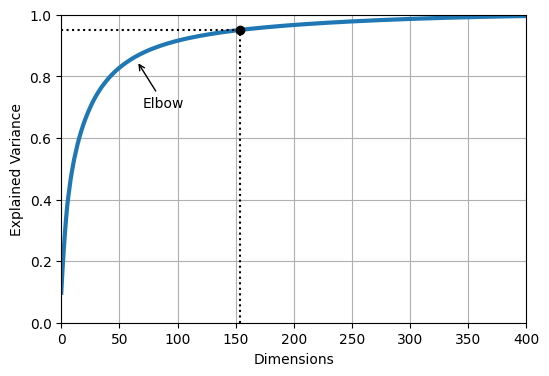

In [28]:
# extra code – this cell generates and saves Figure 8–8

from matplotlib import pyplot as plt


plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [33]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [36]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_test)
X_recovered = pca.inverse_transform(X_reduced)
print(X_recovered)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [37]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [38]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [39]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode='write', shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

In [40]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

In [42]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, E = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=E)
print(d)

7300


In [45]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)
X = np.random.randn(m, n)

X_reduced = X @ P.T

print(X_reduced)

[[ 0.65601016 -1.52157349 -2.13016582 ... -3.30298058  1.86509223
  -0.62205374]
 [-1.15983875 -1.31973727  0.13553982 ... -0.9461484  -0.01875402
   1.15834454]
 [-2.79258363  0.47631317 -3.2293912  ...  1.41899815  3.03817514
  -2.07598188]
 ...
 [ 0.18867284  0.58379053  1.42444552 ...  0.13507484  1.83874287
  -0.39265772]
 [ 2.54718434  0.32063561 -3.59830134 ...  0.49247486  0.46798188
   0.09910125]
 [ 3.68422382 -2.65487692  0.55763148 ...  2.14734207 -1.82840766
   0.76915154]]


In [47]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_random_projection = GaussianRandomProjection(eps=E, random_state=42)
X_reduced = gaussian_random_projection.fit_transform(X)

print(X_reduced)

[[ 0.65601016 -1.52157349 -2.13016582 ... -3.30298058  1.86509223
  -0.62205374]
 [-1.15983875 -1.31973727  0.13553982 ... -0.9461484  -0.01875402
   1.15834454]
 [-2.79258363  0.47631317 -3.2293912  ...  1.41899815  3.03817514
  -2.07598188]
 ...
 [ 0.18867284  0.58379053  1.42444552 ...  0.13507484  1.83874287
  -0.39265772]
 [ 2.54718434  0.32063561 -3.59830134 ...  0.49247486  0.46798188
   0.09910125]
 [ 3.68422382 -2.65487692  0.55763148 ...  2.14734207 -1.82840766
   0.76915154]]


In [48]:
components_pinv = np.linalg.pinv(gaussian_random_projection.components_)
X_recovered = X_reduced @ components_pinv.T

In [49]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

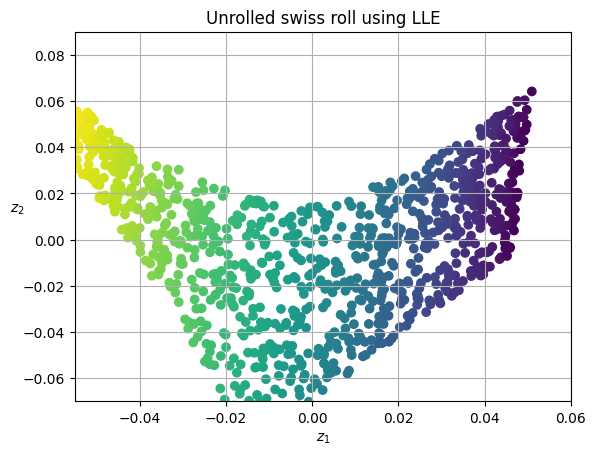

In [50]:
# extra code – this cell generates and saves Figure 8–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

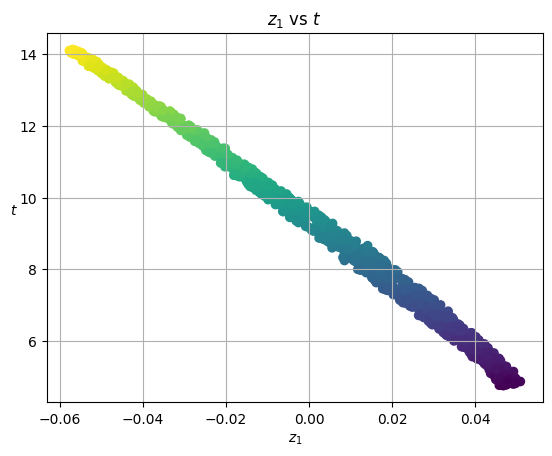

In [51]:
# extra code – shows how well correlated z1 is to t: LLE worked fine
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

In [52]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [53]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

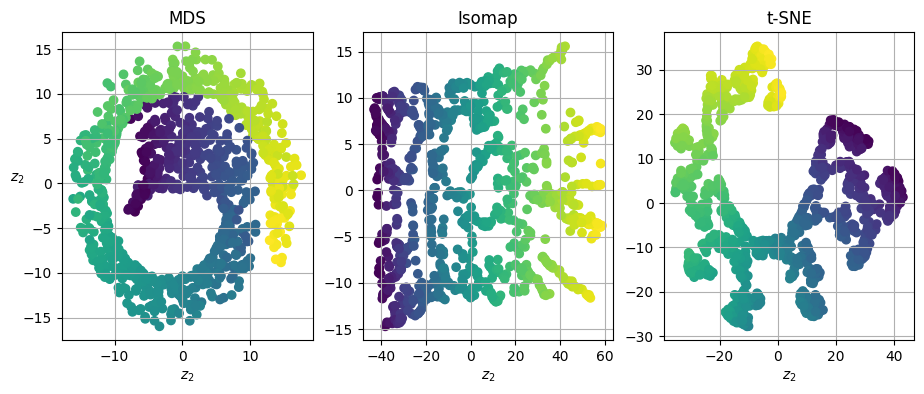

In [55]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip(
    (131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)
):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t)
    plt.xlabel("$z_2$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

**Ex 1:**
- the motivation is to improve training time
- The drawback is information loss


**Ex 2:**
- The curse of dimensionality is the idea that dimensions exponentially increase complexity


**Ex 3:**
- Yes you can reverse dimensionality by taking the inverse?


**Ex 4:**
- Yes it mainly focuses on dimensionality


**Ex 5:**
- There is some equation here that I do not remember


**EX 6:**
- You use incremental PCA when the data is too large to fit into memory
- Regular PCA? when the data is normal
- Randomized PCA? too many dimensions?
- Random projection? too much variance?


**EX 7:**
- You can evaluate the performance by running a fit and projection on the new dimension set and measure the information loss


**EX 8:**
- Chaining? Maybe when you are trying to keep as much information as possible?